<a href="https://colab.research.google.com/github/asegura4488/CienciaDatos/blob/main/Semana6/SegmentacionImagenes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import cv2
import numpy as np
import numpy.typing as npt
from pathlib import Path
from skimage import color as skcolor
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
from google.colab import files
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import seaborn as sns
import os
os.chdir('/content/drive/MyDrive/ColabNotebooks/Cursos/CursoCienciaDatos/Semana6/Datos')
!ls

Churn_Modelling.csv  img


In [ ]:
root = "./img"

In [ ]:
def read_rgb_float01(path: str):
    """cv2.imread -> RGB float32 en [0,1]"""
    arr = cv2.imread(path, cv2.IMREAD_COLOR)
    if arr is None:
        raise FileNotFoundError(f"No se puede leer: {path}")
    arr = cv2.cvtColor(arr, cv2.COLOR_BGR2RGB)
    return (arr.astype(np.float32) / 255.0)

def normalize_img(img: np.ndarray, rimg: np.ndarray, eps: float = 1e-8) -> np.ndarray:
    """Normaliza por imagen de referencia, resultado en [0,1]."""
    norm = img / (rimg + eps)
    norm = np.nan_to_num(norm, nan=0.0, posinf=0.0, neginf=0.0)
    return np.clip(norm, 0.0, 1.0).astype(np.float32)

In [ ]:
pairs = []
for ref_path in Path(root).rglob("*_ref.png"):
    img_path = Path(str(ref_path).replace("_ref.png", ".png"))
    if img_path.exists():
        pairs.append((img_path, ref_path))

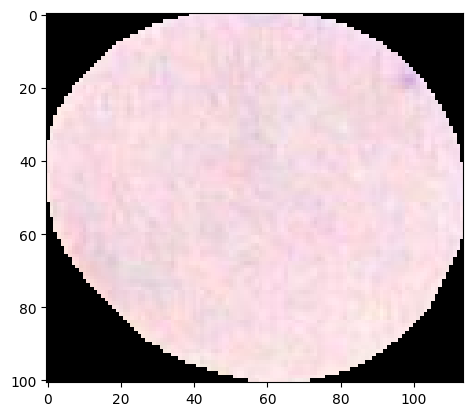

In [ ]:
img = cv2.imread("./img/000_seg_016.png", cv2.IMREAD_COLOR)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = img.astype(np.float32) / 255.0
plt.imshow(img)

In [ ]:
# Definimos funcion de agrupacion
def kmeans_lab_segments(rgb_float: np.ndarray, K: int = 4, max_iter: int = 60, attemps: int = 20):

  lab = skcolor.rgb2lab(rgb_float)
  h, w, _ = lab.shape
  samples = lab.reshape((-1, 3)).astype(np.float32)

  criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, max_iter, 1.0)
  compactess, labels, centers = cv2.kmeans(samples, K, None, criteria, attemps, cv2.KMEANS_PP_CENTERS)
  labels = labels.flatten()
  segmented_lab = centers[labels.flatten()].reshape((h,w,3))

  return labels, centers, segmented_lab, lab

In [ ]:
def plot_rgb_histogram(img):

  plt.figure(figsize=(6,4))
  for i, name in enumerate(('R','G','B')):
    hist, bins = np.histogram(img[:,:,i].ravel(), bins=256, range=(0,1))
    plt.plot(bins[:-1], hist, label=name)

  plt.xlabel('Intensidad')
  plt.ylabel('Frecuencia')
  plt.tight_layout()
  plt.legend()
  plt.show()

In [ ]:
def cluster_dispersion(lab_image, labels, centers):

  X = lab_image.reshape((-1,3))
  dispersiones = []
  for k in range(centers.shape[0]):
    pts = X[labels == k]
    if pts.shape[0] == 0:
      dispersiones.append(np.nan)
    else:
      d2 = np.sum( (pts - centers[k])**2, axis=1 )
      dispersiones.append(np.mean(d2))
  return np.array(dispersiones)

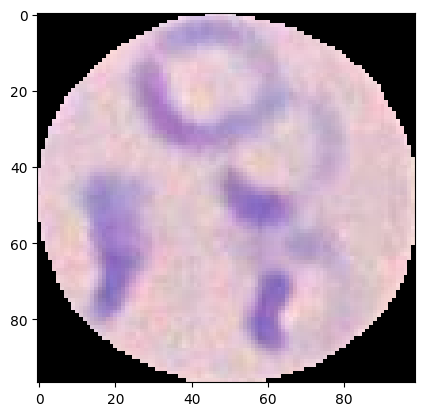

In [ ]:
img = cv2.imread("./img/000_seg_000.png", cv2.IMREAD_COLOR)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = img.astype(np.float32) / 255.0
plt.imshow(img)

In [ ]:
labels, centers, segmented_lab, lab_img = kmeans_lab_segments(img,K=4)
centers

array([[  0.       ,   0.       ,   0.       ],
       [ 82.5734   ,  12.122443 ,  -1.1528349],
       [ 59.57591  ,  25.84893  , -30.190567 ],
       [ 73.41363  ,  16.108076 , -13.8567095]], dtype=float32)

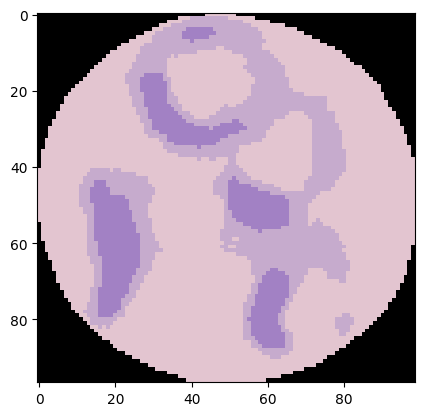

In [ ]:
seg_rgb = skcolor.lab2rgb(segmented_lab)
plt.imshow(seg_rgb)

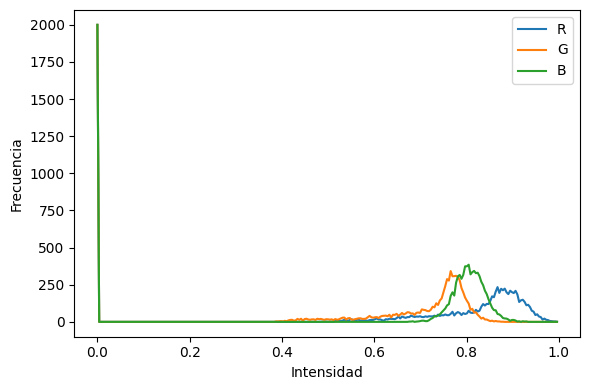

In [ ]:
plot_rgb_histogram(img)

In [ ]:
disp = cluster_dispersion(lab_img, labels, centers)
disp

array([ 0.      , 25.126406, 73.28876 , 41.84343 ], dtype=float32)

img/000_seg_001.png img/000_seg_001_ref.png
img/000_seg_002.png img/000_seg_002_ref.png
img/000_seg_000.png img/000_seg_000_ref.png


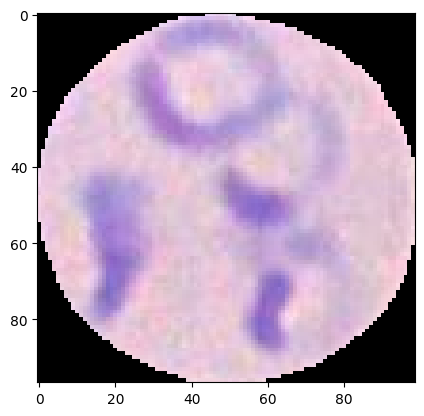

In [ ]:
for (img_path, ref_path) in pairs:
  print(img_path,ref_path)
  img  = read_rgb_float01(str(img_path))
  rimg = read_rgb_float01(str(ref_path))
  norm = normalize_img(img, rimg)
  plt.imshow(norm)

  #plt.imshow(img)